In [5]:
import jax 
import jax.numpy as jnp
import equinox as eqx
import optax   
import matplotlib.pyplot as plt
from typing import List

In [6]:
# nr of samples 
N_SAMPLES = 200

# one 1-node input, three 10-node hidden layers, and one 1-node output.
LAYERS = [1, 10, 10, 10, 1]

# set learning rate 
LEARNING_RATE = 0.1 

# set nr epochs 
N_EPOCHS = 30_000

In [ ]:
# Data generation. Want to simulate a sinus wave with random feature and random y. 

# setting up random key so we can reproduce results
key = jax.random.key(42)
   

In [11]:
# want keys for features and target. 
key, xkey, ykey = jax.random.split(key, 3) 

(200, 1) (200, 1)


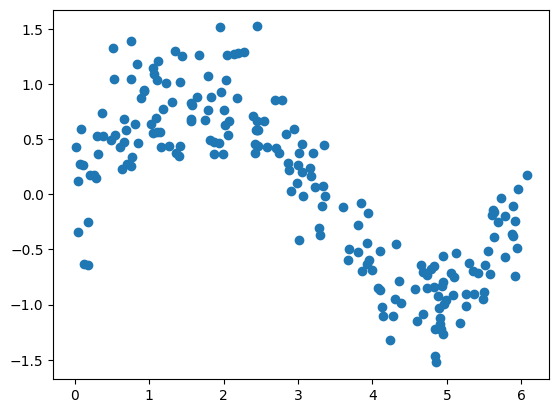

In [43]:
  # pick random values between 0-2pi. x-axis is out feature

# scale of the noise of y 
normal_scale = 0.3 

# pick N_SAMPLES uniform distributed values in [0,2pi). shape = (samples, features)
x_samples = jax.random.uniform(xkey, shape=(N_SAMPLES, 1), minval=0.0, maxval=2.0 *jnp.pi)

# evalute sin at x_samples with added scaled normal distributed noise. 
y_samples = jnp.sin(x_samples) + jax.random.normal(ykey, shape=(N_SAMPLES, 1)) * normal_scale

print(x_samples.shape, y_samples.shape)
plt.scatter(x_samples, y_samples)

In [51]:
print(LAYERS)
print(LAYERS[:-1])
print(LAYERS[1:])
print(list(zip(LAYERS[:-1], LAYERS[1:])))

[1, 10, 10, 10, 1]
[1, 10, 10, 10]
[10, 10, 10, 1]
[(1, 10), (10, 10), (10, 10), (10, 1)]


In [ ]:
# defining a simple feed-forward multi-layered perceptron. 

class simpleMLP(eqx.Module):
    layers: List[eqx.nn.Linear]

    def __init__(self, list_layer_size, layer_key):
        self.layers = []

        # layer transitions 
        for (in_size,out_size) in zip(list_layer_size[:-1], list_layer_size[1:]):
            key, subkey = jax.random.split(key) # default split into two keys
            self.layers.append(
                eqx.nn.Linear(in_size,out_size, use_bias=True, key = subkey)
            )
         
         def __call__(self, x):
             
             

